In [227]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

### Data Exploration

In [105]:
insurance_payout = pd.read_csv("expenses.csv")
insurance_payout.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [106]:
print("Shape : " , insurance_payout.shape)
print(insurance_payout.info())


Shape :  (1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [107]:
print("numeric columns : \n",insurance_payout.describe())

numeric columns : 
                age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [108]:
print("numeric columns : \n",insurance_payout.describe(include=object))

numeric columns : 
          sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364


In [109]:
insurance_payout.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [110]:
insurance_payout["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

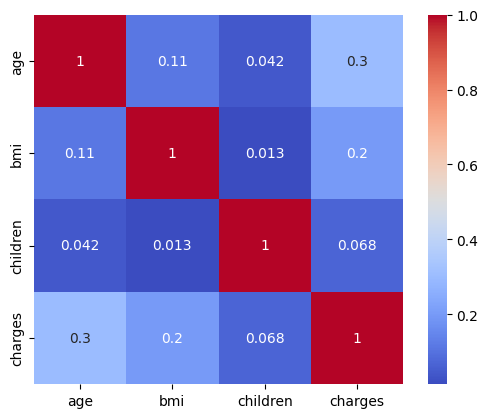

In [111]:
corr_matrix = insurance_payout.corr(numeric_only=True)
sns.heatmap(corr_matrix,annot=True,square=True,cmap="coolwarm")
plt.show()


### Data Visualization

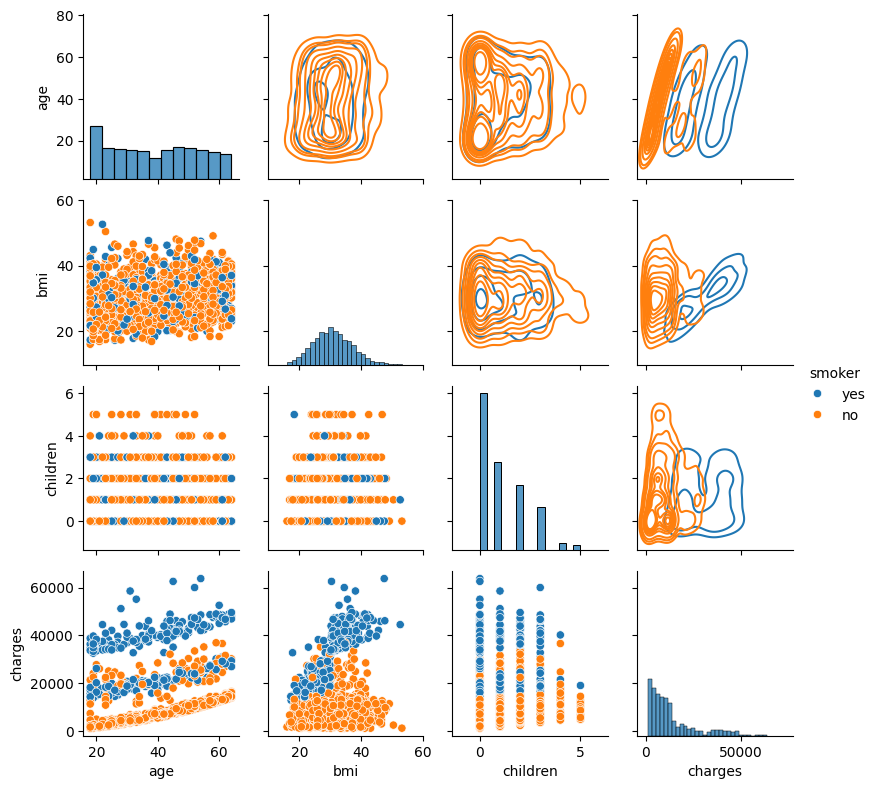

In [112]:
g= sns.PairGrid(insurance_payout,hue="smoker",height=2)
g.map_diag(sns.histplot,hue=None)
g.map_upper(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.add_legend()

<Axes: xlabel='smoker', ylabel='count'>

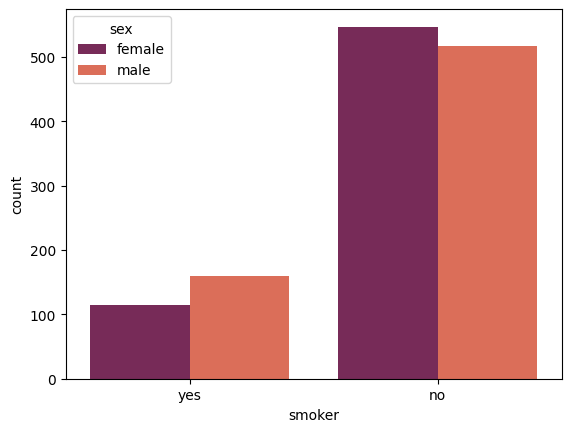

In [113]:
sns.countplot(data=insurance_payout,x='smoker',hue="sex",palette="rocket")

<Axes: xlabel='sex', ylabel='bmi'>

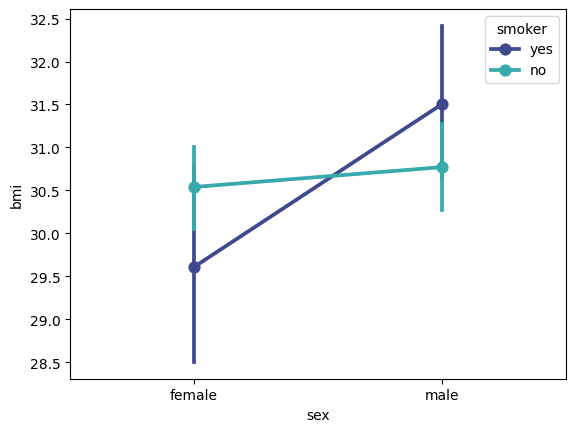

In [114]:
sns.pointplot(insurance_payout,x="sex",y="bmi",hue="smoker",palette="mako")

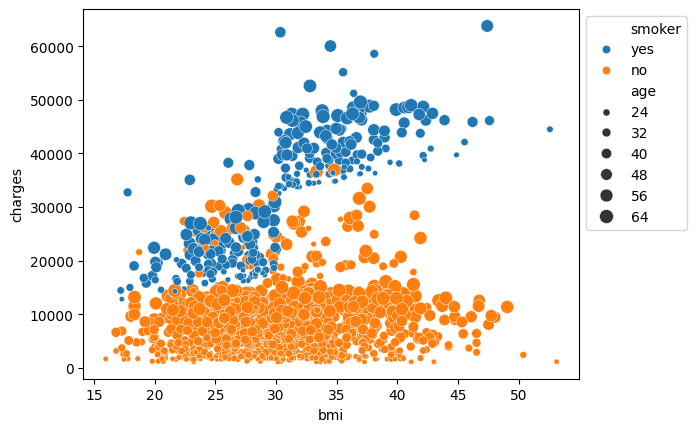

In [115]:
sns.scatterplot(insurance_payout,y="charges",x="bmi",hue="smoker",size="age", sizes=(15, 100))
plt.legend(loc='best',bbox_to_anchor=(1, 1))

### Data Preprocessing

In [147]:
x = insurance_payout.drop("charges",axis=1)
y = insurance_payout["charges"]
x.shape


(1338, 6)

In [148]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size = 0.7)

In [149]:
categorical_cols= x.select_dtypes(include=object).columns
print(categorical_cols)

Index(['sex', 'smoker', 'region'], dtype='object')


In [150]:
numeric_cols = x.select_dtypes(include=[int,float]).columns
print(numeric_cols)

Index(['age', 'bmi', 'children'], dtype='object')


In [152]:
Full_Pipeline = ColumnTransformer(
    [
        ('Onehot', OneHotEncoder(handle_unknown = 'ignore',drop="first"),["region"]),
        ('Ordinal', OrdinalEncoder(),["sex","smoker"]),
        ('standardize', StandardScaler(),["bmi",'children','age']),
        #('normalize',MinMaxScaler(),['children','age'])
    ]
)

x_train_prepared = Full_Pipeline.fit_transform(x_train)
x_test_prepared = Full_Pipeline.fit_transform(x_test)
x_train_prepared = pd.DataFrame(data = x_train_prepared, columns=Full_Pipeline.get_feature_names_out())
x_test_prepared = pd.DataFrame(data = x_test_prepared, columns=Full_Pipeline.get_feature_names_out())


In [153]:
print("Training sample shape : " ,x_train_prepared.shape)
print("Testing sample shape : ",x_test_prepared.shape)

Training sample shape :  (936, 8)
Testing sample shape :  (402, 8)


In [154]:
robust_scale = MinMaxScaler()
y_train= np.array(y_train)
y_train=y_train.reshape(-1,1)

y_test= np.array(y_test)
y_test=y_test.reshape(-1,1)

y_train_prepared = robust_scale.fit_transform(y_train) 
y_test_prepared = robust_scale.fit_transform(y_test) 

# Models 

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
y_train_preparedR  = y_train_prepared.ravel()

### Random Forest Reg

In [69]:
random_forest_reg = RandomForestRegressor()
rfr_param = [{'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
            'max_depth' :[None,3,4,5] , 'n_estimators': [100,200,300]
            }] 

grid_search2= GridSearchCV(random_forest_reg,rfr_param,cv=10,scoring='r2')
grid_search2.fit(x_train_prepared,y_train_preparedR)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'criterion': ['squared_error', 'absolute_error',
                                        'friedman_mse', 'poisson'],
                          'max_depth': [None, 3, 4, 5],
                          'n_estimators': [100, 200, 300]}],
             scoring='r2')

In [70]:
random_forest_reg=grid_search2.best_estimator_
print("Best Score : " ,grid_search2.best_score_)
print("Best params : ",grid_search2.best_params_)

Best Score :  0.8318212576228952
Best params :  {'criterion': 'poisson', 'max_depth': 4, 'n_estimators': 100}


In [138]:
y_pred_scaled2 = grid_search2.predict(x_test_prepared)
y_pred2 = robust_scale.inverse_transform(y_pred_scaled2.reshape(-1,1))

r2Score = r2_score(y_pred_scaled2,y_test_prepared)
print("R2  = ",r2Score)

R2  =  0.7456053588287679


### Gradient Boosting Regressor

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

In [73]:
Gradient_boosting_reg = GradientBoostingRegressor()
gbr_param = [{'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
            'learning_rate':[0.001,0.01,0.1] , "n_estimators":[100,200],
            "max_depth":[2,3,4]
            }] 

grid_search3= GridSearchCV(Gradient_boosting_reg,gbr_param,cv=10,scoring='r2')
grid_search3.fit(x_train_prepared,y_train_preparedR)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid=[{'learning_rate': [0.001, 0.01, 0.1],
                          'loss': ['squared_error', 'absolute_error', 'huber',
                                   'quantile'],
                          'max_depth': [2, 3, 4], 'n_estimators': [100, 200]}],
             scoring='r2')

In [74]:
Gradient_boosting_reg =grid_search3.best_estimator_
print("Best Score : " ,grid_search3.best_score_)
print("Best params : ",grid_search3.best_params_)

Best Score :  0.8344401412525924
Best params :  {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 2, 'n_estimators': 100}


In [75]:
y_pred_scaled3 = grid_search3.predict(x_test_prepared)
y_pred3 = robust_scale.inverse_transform(y_pred_scaled3.reshape(-1,1))

r2Score = r2_score(y_pred_scaled3,y_test_prepared)
print("R2  = ",r2Score)

R2  =  0.7469339637616245


### MLP Regresoor

In [76]:
from sklearn.neural_network import MLPRegressor

In [77]:
MLP_reg = MLPRegressor()
mlp_param = [{"hidden_layer_sizes" :[100,200,300],"activation" :['logistic', 'tanh', 'relu'],
            "learning_rate":["constant","invscaling","adaptive"],"early_stopping":[True],
            }] 

grid_search4= GridSearchCV(MLP_reg,mlp_param,cv=10,scoring='r2')
grid_search4.fit(x_train_prepared,y_train_preparedR)

c:\Users\HP14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\HP14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\HP14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\HP14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

GridSearchCV(cv=10, estimator=MLPRegressor(),
             param_grid=[{'activation': ['logistic', 'tanh', 'relu'],
                          'early_stopping': [True],
                          'hidden_layer_sizes': [100, 200, 300],
                          'learning_rate': ['constant', 'invscaling',
                                            'adaptive']}],
             scoring='r2')

In [78]:
MLP_reg =grid_search4.best_estimator_
print("Best Score : " ,grid_search4.best_score_)
print("Best params : ",grid_search4.best_params_)

Best Score :  0.8212709004015734
Best params :  {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': 300, 'learning_rate': 'adaptive'}


In [79]:
y_pred_scaled4 = grid_search4.predict(x_test_prepared)
y_pred4 = robust_scale.inverse_transform(y_pred_scaled4.reshape(-1,1))

r2Score = r2_score(y_pred_scaled4,y_test_prepared)
print("R2  = ",r2Score)

R2  =  0.749239348863372


### Neural Network

In [156]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam,RMSprop
from keras.layers import BatchNormalization
import kerastuner as kt


In [214]:
def model_builder(hp):
    model = Sequential()
    # Tune the number of neurons in the first Dense layer
    hp_neurons = hp.Int('neurons', min_value=8, max_value=256, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005])
    hp_dropout = hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])
    hp_optimizer = hp.Choice('optimizer', values=['adam','rmsprop'])

    model.add(Dense(hp_neurons, input_shape=(8,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(Dense(hp_neurons // 2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp_dropout))

    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=hp_optimizer,loss='mse',metrics=['mse'])
    
    return model


In [221]:
# Initialize the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='mse',
    max_trials=5,
    executions_per_trial=3,
    directory='insurance_direct3',  
    project_name='insuarance_pro3'
)
early_stopping = keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True,monitor='mse')
# Search for the best hyperparameters
tuner.search(x_train_prepared, y_train_prepared, epochs=500,callbacks=[early_stopping],batch_size = 32)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
print(f"Best number of neurons: {best_hps.get('neurons')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")


Reloading Tuner from insurance_direct3\insuarance_pro3\tuner0.json
Best number of neurons: 232
Best learning rate: 0.0005
Best dropout rate: 0.2


In [204]:
best_model = tuner.get_best_models(num_models=1)[0]
np.sqrt(best_model.evaluate(x_test_prepared, y_test_prepared))

c:\Users\HP14\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\HP14\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - mse: 0.0099  


array([0.10234467, 0.10234467])

In [226]:
y_pred_scalednn = best_model.predict(x_test_prepared)
y_prednn = robust_scale.inverse_transform(y_pred_scalednn.reshape(-1,1))


r2Score = r2_score(y_pred_scalednn,y_test_prepared)
print("R2  = ",r2Score)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
R2  =  0.8032633229226005


In [209]:
results = pd.DataFrame({'Actual': y_test.flatten(),'Predicted': y_prednn.flatten()})

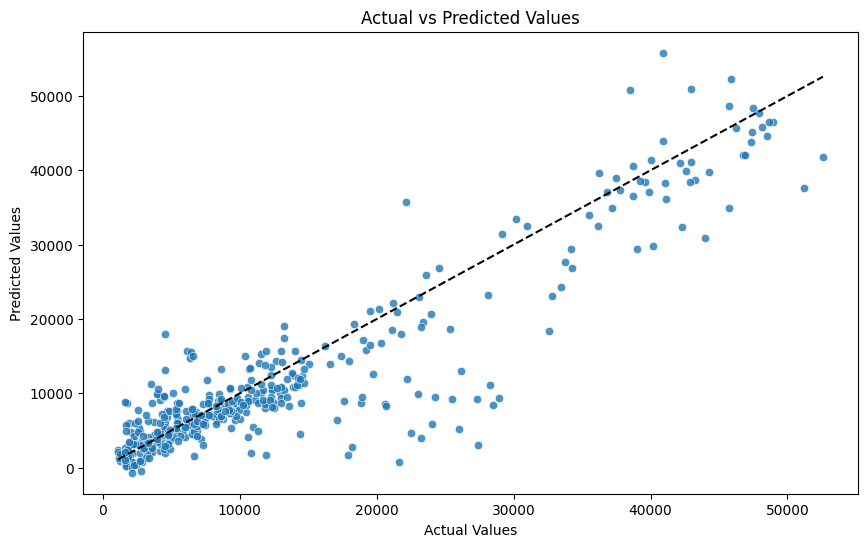

In [210]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='Actual', y='Predicted', alpha=0.8)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()],
         color='black', linestyle='--')  
plt.show()


In [223]:
best_model.save("insurance_model.keras")